In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import gc
import math
from joblib import Parallel, delayed

from tqdm import tqdm
import time
import warnings

warnings.filterwarnings('ignore')

pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

In [2]:
def timestamp2string(timeStamp):
    try:
        d = datetime.fromtimestamp(timeStamp)
        str1 = d.strftime("%Y-%m-%d %H:%M:%S")
        # 2015-08-28 16:43:37'
        return datetime.strptime(str1,'%Y-%m-%d %H:%M:%S')
    except Exception as e:
        return ''

In [3]:
def get_psi(c):
    psi_res = pd.DataFrame()
    psi_dict={}
    # for c in tqdm(f_cols):
    try:
        t_train = x_train[c].fillna(-998)
        t_test = x_test[c].fillna(-998)
        #获取切分点
        bins=[]
        for i in np.arange(0,1.1,0.2):
            bins.append(t_train.quantile(i))
        bins=sorted(set(bins))
        bins[0]=-np.inf
        bins[-1]=np.inf
        #计算psi
        t_psi = pd.DataFrame()
        t_psi['train'] = pd.cut(t_train,bins).value_counts().sort_index()
        t_psi['test'] = pd.cut(t_test,bins).value_counts()
        t_psi.index=[str(x) for x in t_psi.index]
        t_psi.loc['总计',:] = t_psi.sum()
        t_psi['train_rate'] = t_psi['train']/t_psi.loc['总计','train']
        t_psi['test_rate'] = t_psi['test']/t_psi.loc['总计','test']
        t_psi['psi'] = (t_psi['test_rate']-t_psi['train_rate'])*(np.log(t_psi['test_rate'])-np.log(t_psi['train_rate']))
        t_psi.loc['总计','psi'] = t_psi['psi'].sum()
        t_psi.index.name=c
        #汇总
        t_res = pd.DataFrame([[c,t_psi.loc['总计','psi']]],
                             columns=['变量名','PSI'])
        psi_res = pd.concat([psi_res,t_res])
        psi_dict[c]=t_psi
        print(c,'done')
    except:
        print(c,'error')
    return psi_res #, psi_dict

In [4]:
def correlation(df, threshold=0.98):
    """
    特征相关性计算
    @param df: 
    @param threshold: 
    @return: 
    """
    col_corr = set()
    corr_matrix = df.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colName = corr_matrix.columns[i]
                col_corr.add(colName)
    return col_corr

In [5]:
train_df = pd.read_hdf('../../input/train.h5')
test_df = pd.read_hdf('../../input/test.h5')
sub = pd.DataFrame(test_df['time'])

In [6]:
train_df = train_df[train_df['temperature'].notnull()]
train_df = train_df.fillna(method='bfill')
test_df = test_df.fillna(method='bfill')

In [7]:
train_df.columns = ['time', 'year', 'month', 'day', 'hour', 'min', 'sec', 'outdoorTemp', 'outdoorHum', 'outdoorAtmo',
                    'indoorHum', 'indoorAtmo', 'temperature']
test_df.columns = ['time', 'year', 'month', 'day', 'hour', 'min', 'sec', 'outdoorTemp', 'outdoorHum', 'outdoorAtmo',
                   'indoorHum', 'indoorAtmo']

In [8]:
train_df.drop(['year', 'sec'], axis=1, inplace=True)
test_df.drop(['year', 'sec'], axis=1, inplace=True)

In [9]:
print('train_df.shape: ', train_df.shape)
# train_df = train_df.loc[(train_df['outdoorTemp'] >= test_df['outdoorTemp'].min()) & (train_df['outdoorTemp'] <= test_df['outdoorTemp'].max())]
# print('处理后 train_df.shape: ', train_df.shape)

train_df.shape:  (24807, 11)


In [10]:
train_df['indoorHum-outdoorHum'] = train_df['indoorHum'] - train_df['outdoorHum']
train_df['indoorAtmo-outdoorAtmo'] = train_df['indoorAtmo'] - train_df['outdoorAtmo']
train_df['temperature-outdoorTemp'] = train_df['temperature'] - train_df['outdoorTemp']

test_df['indoorHum-outdoorHum'] = test_df['indoorHum'] - test_df['outdoorHum']
test_df['indoorAtmo-outdoorAtmo'] = test_df['indoorAtmo'] - test_df['outdoorAtmo']

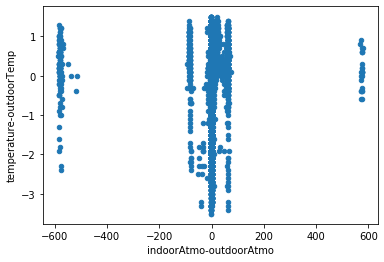

In [11]:
train_df.plot.scatter(x='indoorAtmo-outdoorAtmo', y='temperature-outdoorTemp')

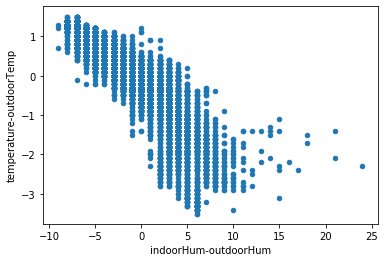

In [12]:
train_df.plot.scatter(x='indoorHum-outdoorHum', y='temperature-outdoorTemp')

In [13]:
print(train_df.loc[(train_df['indoorAtmo-outdoorAtmo'] < 400) & (train_df['indoorAtmo-outdoorAtmo'] > -400)]['indoorAtmo-outdoorAtmo'].max())
print(train_df.loc[(train_df['indoorAtmo-outdoorAtmo'] < 400) & (train_df['indoorAtmo-outdoorAtmo'] > -400)]['indoorAtmo-outdoorAtmo'].min())

74.70000000000005
-92.5


In [14]:
train_df.loc[train_df['indoorAtmo-outdoorAtmo'] > 400, 'indoorAtmo-outdoorAtmo'] = 75
train_df.loc[train_df['indoorAtmo-outdoorAtmo'] < -400, 'indoorAtmo-outdoorAtmo'] = -93

test_df.loc[test_df['indoorAtmo-outdoorAtmo'] > 400, 'indoorAtmo-outdoorAtmo'] = 75
test_df.loc[test_df['indoorAtmo-outdoorAtmo'] < -400, 'indoorAtmo-outdoorAtmo'] = -93

In [15]:
train_df.loc[train_df['indoorHum-outdoorHum'] > 15, 'indoorHum-outdoorHum'] = 15
test_df.loc[test_df['indoorHum-outdoorHum'] > 15, 'indoorHum-outdoorHum'] = 15

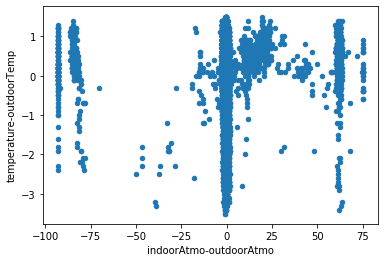

In [16]:
train_df.plot.scatter(x='indoorAtmo-outdoorAtmo', y='temperature-outdoorTemp')

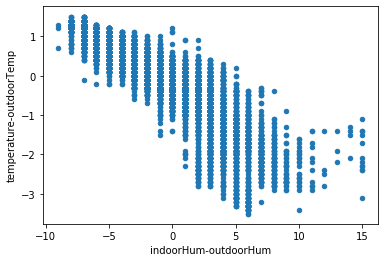

In [17]:
train_df.plot.scatter(x='indoorHum-outdoorHum', y='temperature-outdoorTemp')

In [18]:
train_count = train_df.shape[0]
y_train = train_df['temperature'].values - train_df['outdoorTemp'].values

In [19]:
train_df.shape

(24807, 14)

In [20]:
data_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

del train_df, test_df
gc.collect()

107

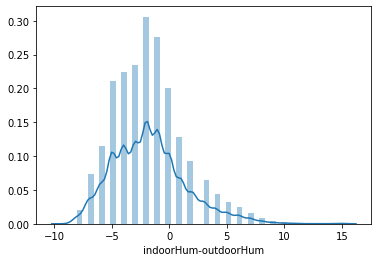

In [21]:
sns.distplot(data_df['indoorHum-outdoorHum'])

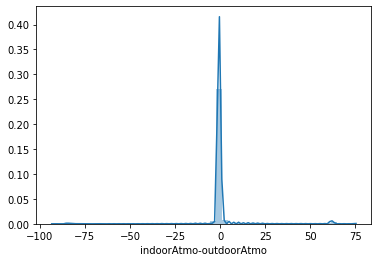

In [22]:
sns.distplot(data_df['indoorAtmo-outdoorAtmo'])

In [23]:
data_df['indoorHum-outdoorHum'].describe()

count    25213.000000
mean        -1.749137
std          3.181537
min         -9.000000
25%         -4.000000
50%         -2.000000
75%          0.000000
max         15.000000
Name: indoorHum-outdoorHum, dtype: float64

In [24]:
data_df['indoorAtmo-outdoorAtmo'].describe()

count    25213.000000
mean        -0.216666
std         12.841312
min        -93.000000
25%         -1.200000
50%         -0.600000
75%          0.100000
max         75.000000
Name: indoorAtmo-outdoorAtmo, dtype: float64

In [25]:
numerical_features = ['outdoorTemp', 'outdoorHum', 'outdoorAtmo', 'indoorHum', 'indoorAtmo', 'indoorHum-outdoorHum', 'indoorAtmo-outdoorAtmo']
diff_features = ['{}_diff'.format(i) for i in numerical_features]
numerical_diff_features = numerical_features + diff_features

In [26]:
for i in tqdm(numerical_features):
    data_df['{}_diff'.format(i)] = data_df[i].diff()

100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1169.49it/s]


In [27]:
data_df.fillna(method='bfill', inplace=True)

## rolling

In [28]:
data_df['datetime'] = data_df['time'].apply(timestamp2string)

### rolling 90min，120min

In [29]:
for i in numerical_features:
    for j in ['90min', '120min']:
        data_df.set_index('datetime', inplace=True)
        tmp = data_df[i].rolling(j, closed='left', min_periods=1).agg({
            '{}_{}_rolling_mean'.format(i, j): 'mean',
            '{}_{}_rolling_median'.format(i, j): 'median',
            '{}_{}_rolling_max'.format(i, j): 'max',
            '{}_{}_rolling_min'.format(i, j): 'min',
            '{}_{}_rolling_sum'.format(i, j): 'sum',
            '{}_{}_rolling_std'.format(i, j): 'std',
            '{}_{}_rolling_skew'.format(i, j): 'skew'
        })
        tmp.reset_index(inplace=True)
        data_df.reset_index(inplace=True)
        data_df = data_df.merge(tmp, on=['datetime'], how='left')
        del tmp
        gc.collect()

### groupby('hour')

In [30]:
for i in numerical_features:
    for j in ['2D', '3D', '4D']:
        data_df.set_index('datetime', inplace=True)
        tmp = data_df.groupby('hour')[i].rolling(j, closed='left', min_periods=1).agg({
            '{}_{}_rolling_mean'.format(i, j): 'mean',
            '{}_{}_rolling_median'.format(i, j): 'median',
            '{}_{}_rolling_max'.format(i, j): 'max',
            '{}_{}_rolling_min'.format(i, j): 'min',
            '{}_{}_rolling_sum'.format(i, j): 'sum',
            '{}_{}_rolling_std'.format(i, j): 'std',
            '{}_{}_rolling_skew'.format(i, j): 'skew'
        })
        tmp.reset_index(inplace=True)
        data_df.reset_index(inplace=True)
        data_df = data_df.merge(tmp, on=['datetime', 'hour'], how='left')
        del tmp
        gc.collect()

## expanding

In [31]:
for i in numerical_features:
    data_df.set_index('datetime', inplace=True)
    tmp = data_df.groupby('hour')[i].expanding(min_periods=1).agg({
        '{}_expanding_mean'.format(i): 'mean',
        '{}_expanding_median'.format(i): 'median',
        '{}_expanding_max'.format(i): 'max',
        '{}_expanding_min'.format(i): 'min',
        '{}_expanding_sum'.format(i): 'sum',
        '{}_expanding_std'.format(i): 'std',
        '{}_expanding_skew'.format(i): 'skew',
    })
    tmp.reset_index(inplace=True)
    data_df.reset_index(inplace=True)
    data_df = data_df.merge(tmp, on=['datetime', 'hour'], how='left')
    del tmp
    gc.collect()

In [32]:
data_df.drop('datetime', axis=1, inplace=True)

In [33]:
data_df.fillna(method='bfill', inplace=True)

## 历史信息

In [34]:
data_df['dt'] = data_df['day'].values + (data_df['month'].values - 3) * 31

In [35]:
data_df['dt'].unique()

array([14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
       31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44],
      dtype=int64)

In [36]:
for f in (numerical_features + ['temperature']):
    tmp_df = pd.DataFrame()
    for t in tqdm(range(15, 46)):
        tmp = data_df.loc[data_df['dt'] < t, :].groupby(['hour'], as_index=False)[f].agg({
            'hit_{}_mean'.format(f): 'mean',
            'hit_{}_median'.format(f): 'median',
            'hit_{}_max'.format(f): 'max',
            'hit_{}_min'.format(f): 'min',
            'hit_{}_sum'.format(f): 'sum',
            'hit_{}_std'.format(f): 'std',
            'hit_{}_skew'.format(f): 'skew'
        })
        tmp['dt'] = t - 1
        tmp_df = tmp_df.append(tmp)
        del tmp
        gc.collect()
    
    data_df = data_df.merge(tmp_df, on=['dt', 'hour'], how='left')
    del tmp_df
    gc.collect()

    
for f in (numerical_features + ['temperature']):
    tmp_df = pd.DataFrame()
    for t in tqdm(range(16, 46)):
        tmp = data_df.loc[(data_df['dt'] < t) & (data_df['dt'] >= t - 2), :].groupby(['hour'], as_index=False)[f].agg({
            'hit_t_2_{}_mean'.format(f): 'mean',
            'hit_t_2_{}_median'.format(f): 'median',
            'hit_t_2_{}_max'.format(f): 'max',
            'hit_t_2_{}_min'.format(f): 'min',
            'hit_t_2_{}_sum'.format(f): 'sum',
            'hit_t_2_{}_std'.format(f): 'std',
            'hit_t_2_{}_skew'.format(f): 'skew'
        })
        tmp['dt'] = t - 1
        tmp_df = tmp_df.append(tmp)
        del tmp
        gc.collect()

    data_df = data_df.merge(tmp_df, on=['dt', 'hour'], how='left')
    del tmp_df
    gc.collect()

    
for f in (numerical_features + ['temperature']):
    tmp_df = pd.DataFrame()
    for t in tqdm(range(17, 46)):
        tmp = data_df.loc[(data_df['dt'] < t) & (data_df['dt'] >= t - 3), :].groupby(['hour'], as_index=False)[f].agg({
            'hit_t_3_{}_mean'.format(f): 'mean',
            'hit_t_3_{}_median'.format(f): 'median',
            'hit_t_3_{}_max'.format(f): 'max',
            'hit_t_3_{}_min'.format(f): 'min',
            'hit_t_3_{}_sum'.format(f): 'sum',
            'hit_t_3_{}_std'.format(f): 'std',
            'hit_t_3_{}_skew'.format(f): 'skew'
        })
        tmp['dt'] = t - 1
        tmp_df = tmp_df.append(tmp)
        del tmp
        gc.collect()

    data_df = data_df.merge(tmp_df, on=['dt', 'hour'], how='left')
    del tmp_df
    gc.collect()

for f in (numerical_features + ['temperature']):
    tmp_df = pd.DataFrame()
    for t in tqdm(range(18, 46)):
        tmp = data_df.loc[(data_df['dt'] < t) & (data_df['dt'] >= t - 4), :].groupby(['hour'], as_index=False)[f].agg({
            'hit_t_4_{}_mean'.format(f): 'mean',
            'hit_t_4_{}_median'.format(f): 'median',
            'hit_t_4_{}_max'.format(f): 'max',
            'hit_t_4_{}_min'.format(f): 'min',
            'hit_t_4_{}_sum'.format(f): 'sum',
            'hit_t_4_{}_std'.format(f): 'std',
            'hit_t_4_{}_skew'.format(f): 'skew'
        })
        tmp['dt'] = t - 1
        tmp_df = tmp_df.append(tmp)
        del tmp
        gc.collect()

    data_df = data_df.merge(tmp_df, on=['dt', 'hour'], how='left')
    del tmp_df
    gc.collect()

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 18.51it/s]


## 计算psi

In [37]:
train_df = data_df[:train_count].copy().reset_index(drop=True)
test_df = data_df[train_count:].copy().reset_index(drop=True)

del data_df
gc.collect()

20

In [38]:
train_time = train_df['time']
test_time = test_df['time']

In [39]:
drop_columns = ["time", "temperature"]

features = train_df[:1].drop(drop_columns, axis=1).columns
x_train = train_df[features]
x_test = test_df[features]

In [40]:
print(len(features))

538


In [41]:
psi_res = Parallel(n_jobs=4)(delayed(get_psi)(c) for c in tqdm(features))
psi_df = pd.concat(psi_res)

100%|████████████████████████████████████████████████████████████████████████████████| 538/538 [00:05<00:00, 99.85it/s]


In [42]:
features = list(psi_df[psi_df['PSI'] > 0.2]['变量名'].values)

In [43]:
print(features)

['day', 'outdoorTemp', 'outdoorHum', 'outdoorAtmo', 'indoorAtmo', 'temperature-outdoorTemp', 'outdoorTemp_diff', 'outdoorHum_diff', 'outdoorAtmo_diff', 'indoorHum_diff', 'indoorAtmo_diff', 'indoorAtmo-outdoorAtmo_diff', 'outdoorTemp_90min_rolling_mean', 'outdoorTemp_90min_rolling_median', 'outdoorTemp_90min_rolling_max', 'outdoorTemp_90min_rolling_min', 'outdoorTemp_90min_rolling_sum', 'outdoorTemp_90min_rolling_skew', 'outdoorTemp_120min_rolling_mean', 'outdoorTemp_120min_rolling_median', 'outdoorTemp_120min_rolling_max', 'outdoorTemp_120min_rolling_min', 'outdoorTemp_120min_rolling_sum', 'outdoorTemp_120min_rolling_skew', 'outdoorHum_90min_rolling_mean', 'outdoorHum_90min_rolling_median', 'outdoorHum_90min_rolling_max', 'outdoorHum_90min_rolling_sum', 'outdoorHum_90min_rolling_skew', 'outdoorHum_120min_rolling_mean', 'outdoorHum_120min_rolling_median', 'outdoorHum_120min_rolling_max', 'outdoorHum_120min_rolling_sum', 'outdoorHum_120min_rolling_skew', 'outdoorAtmo_90min_rolling_mean',

In [44]:
print(len(features))

407


In [45]:
x_train.drop(features, axis=1, inplace=True)
x_test.drop(features, axis=1, inplace=True)
gc.collect()

257

In [46]:
x_train.shape

(24807, 131)

In [47]:
x_train.head(10).append(x_train.tail(10))

,month,hour,min,indoorHum,indoorHum-outdoorHum,indoorAtmo-outdoorAtmo,indoorHum-outdoorHum_diff,outdoorTemp_90min_rolling_std,outdoorTemp_120min_rolling_std,outdoorHum_90min_rolling_min,outdoorHum_90min_rolling_std,outdoorHum_120min_rolling_min,outdoorHum_120min_rolling_std,indoorHum_90min_rolling_mean,indoorHum_90min_rolling_median,indoorHum_90min_rolling_min,indoorHum_120min_rolling_mean,indoorHum_120min_rolling_median,indoorHum_120min_rolling_min,indoorHum_120min_rolling_std,indoorHum-outdoorHum_90min_rolling_mean,indoorHum-outdoorHum_90min_rolling_median,indoorHum-outdoorHum_90min_rolling_max,indoorHum-outdoorHum_120min_rolling_mean,indoorHum-outdoorHum_120min_rolling_median,indoorHum-outdoorHum_120min_rolling_max,outdoorTemp_2D_rolling_std,outdoorTemp_3D_rolling_std,outdoorTemp_3D_rolling_skew,outdoorTemp_4D_rolling_std,outdoorTemp_4D_rolling_skew,outdoorHum_2D_rolling_mean,outdoorHum_2D_rolling_median,outdoorHum_2D_rolling_min,outdoorHum_2D_rolling_std,outdoorHum_3D_rolling_min,outdoorHum_3D_rolling_std,outdoorHum_3D_rolling_skew,outdoorHum_4D_rolling_min,outdoorHum_4D_rolling_std,outdoorHum_4D_rolling_skew,indoorHum_2D_rolling_mean,indoorHum_2D_rolling_median,indoorHum_2D_rolling_min,indoorHum_2D_rolling_std,indoorHum_3D_rolling_min,indoorHum_3D_rolling_std,indoorHum_3D_rolling_skew,indoorHum_4D_rolling_median,indoorHum_4D_rolling_min,indoorHum_4D_rolling_std,indoorHum_4D_rolling_skew,indoorAtmo_2D_rolling_mean,indoorHum-outdoorHum_2D_rolling_mean,indoorHum-outdoorHum_2D_rolling_median,indoorHum-outdoorHum_2D_rolling_max,indoorHum-outdoorHum_2D_rolling_std,indoorHum-outdoorHum_3D_rolling_mean,indoorHum-outdoorHum_3D_rolling_median,indoorHum-outdoorHum_3D_rolling_max,indoorHum-outdoorHum_3D_rolling_std,indoorHum-outdoorHum_3D_rolling_skew,indoorHum-outdoorHum_4D_rolling_mean,indoorHum-outdoorHum_4D_rolling_max,indoorHum-outdoorHum_4D_rolling_std,indoorHum-outdoorHum_4D_rolling_skew,indoorAtmo-outdoorAtmo_3D_rolling_mean,indoorAtmo-outdoorAtmo_4D_rolling_mean,outdoorHum_expanding_median,indoorHum_expanding_median,indoorAtmo_expanding_max,indoorHum-outdoorHum_expanding_mean,indoorHum-outdoorHum_expanding_median,indoorAtmo-outdoorAtmo_expanding_min,indoorAtmo-outdoorAtmo_expanding_sum,indoorAtmo-outdoorAtmo_expanding_std,indoorAtmo-outdoorAtmo_expanding_skew,hit_outdoorTemp_median,hit_outdoorHum_mean,hit_outdoorHum_median,hit_indoorHum_median,hit_indoorAtmo_max,hit_indoorAtmo_std,hit_indoorHum-outdoorHum_mean,hit_indoorHum-outdoorHum_median,hit_indoorHum-outdoorHum_skew,hit_indoorAtmo-outdoorAtmo_min,hit_indoorAtmo-outdoorAtmo_sum,hit_indoorAtmo-outdoorAtmo_std,hit_indoorAtmo-outdoorAtmo_skew,hit_t_2_outdoorTemp_std,hit_t_2_outdoorTemp_skew,hit_t_2_outdoorHum_mean,hit_t_2_outdoorHum_median,hit_t_2_outdoorHum_min,hit_t_2_outdoorHum_std,hit_t_2_indoorHum_mean,hit_t_2_indoorHum_median,hit_t_2_indoorHum_max,hit_t_2_indoorHum_min,hit_t_2_indoorHum_std,hit_t_2_indoorAtmo_mean,hit_t_2_indoorHum-outdoorHum_max,hit_t_2_indoorHum-outdoorHum_std,hit_t_3_outdoorTemp_std,hit_t_3_outdoorTemp_skew,hit_t_3_outdoorHum_mean,hit_t_3_outdoorHum_median,hit_t_3_outdoorHum_max,hit_t_3_outdoorHum_min,hit_t_3_outdoorHum_std,hit_t_3_outdoorAtmo_mean,hit_t_3_indoorHum_mean,hit_t_3_indoorHum_median,hit_t_3_indoorHum_max,hit_t_3_indoorHum_min,hit_t_3_indoorHum_std,hit_t_3_indoorAtmo_mean,hit_t_3_indoorHum-outdoorHum_max,hit_t_3_indoorHum-outdoorHum_std,hit_t_3_indoorHum-outdoorHum_skew,hit_t_4_outdoorTemp_skew,hit_t_4_outdoorHum_mean,hit_t_4_outdoorHum_median,hit_t_4_outdoorAtmo_mean,hit_t_4_outdoorAtmo_median,hit_t_4_indoorHum_mean,hit_t_4_indoorHum_median,hit_t_4_indoorHum_max,hit_t_4_indoorAtmo_mean,hit_t_4_indoorHum-outdoorHum_skew
0,3,1,0,80.0,-5.0,-0.7,1.0,0.070711,0.070711,85.0,0.707107,85.0,0.707107,80.000000,80.0,80.0,80.000000,80.0,80.0,0.000000,-5.000000,-5.0,-5.0,-5.000000,-5.0,-5.0,0.070711,0.070711,-1.732051e+00,0.070711,-1.732051e+00,85.000000,85.0,85.0,0.707107,85.0,0.707107,1.732051,85.0,0.707107,1.732051,80.000000,80.0,80.0,0.000000,8

In [48]:
x_test.head()

,month,hour,min,indoorHum,indoorHum-outdoorHum,indoorAtmo-outdoorAtmo,indoorHum-outdoorHum_diff,outdoorTemp_90min_rolling_std,outdoorTemp_120min_rolling_std,outdoorHum_90min_rolling_min,outdoorHum_90min_rolling_std,outdoorHum_120min_rolling_min,outdoorHum_120min_rolling_std,indoorHum_90min_rolling_mean,indoorHum_90min_rolling_median,indoorHum_90min_rolling_min,indoorHum_120min_rolling_mean,indoorHum_120min_rolling_median,indoorHum_120min_rolling_min,indoorHum_120min_rolling_std,indoorHum-outdoorHum_90min_rolling_mean,indoorHum-outdoorHum_90min_rolling_median,indoorHum-outdoorHum_90min_rolling_max,indoorHum-outdoorHum_120min_rolling_mean,indoorHum-outdoorHum_120min_rolling_median,indoorHum-outdoorHum_120min_rolling_max,outdoorTemp_2D_rolling_std,outdoorTemp_3D_rolling_std,outdoorTemp_3D_rolling_skew,outdoorTemp_4D_rolling_std,outdoorTemp_4D_rolling_skew,outdoorHum_2D_rolling_mean,outdoorHum_2D_rolling_median,outdoorHum_2D_rolling_min,outdoorHum_2D_rolling_std,outdoorHum_3D_rolling_min,outdoorHum_3D_rolling_std,outdoorHum_3D_rolling_skew,outdoorHum_4D_rolling_min,outdoorHum_4D_rolling_std,outdoorHum_4D_rolling_skew,indoorHum_2D_rolling_mean,indoorHum_2D_rolling_median,indoorHum_2D_rolling_min,indoorHum_2D_rolling_std,indoorHum_3D_rolling_min,indoorHum_3D_rolling_std,indoorHum_3D_rolling_skew,indoorHum_4D_rolling_median,indoorHum_4D_rolling_min,indoorHum_4D_rolling_std,indoorHum_4D_rolling_skew,indoorAtmo_2D_rolling_mean,indoorHum-outdoorHum_2D_rolling_mean,indoorHum-outdoorHum_2D_rolling_median,indoorHum-outdoorHum_2D_rolling_max,indoorHum-outdoorHum_2D_rolling_std,indoorHum-outdoorHum_3D_rolling_mean,indoorHum-outdoorHum_3D_rolling_median,indoorHum-outdoorHum_3D_rolling_max,indoorHum-outdoorHum_3D_rolling_std,indoorHum-outdoorHum_3D_rolling_skew,indoorHum-outdoorHum_4D_rolling_mean,indoorHum-outdoorHum_4D_rolling_max,indoorHum-outdoorHum_4D_rolling_std,indoorHum-outdoorHum_4D_rolling_skew,indoorAtmo-outdoorAtmo_3D_rolling_mean,indoorAtmo-outdoorAtmo_4D_rolling_mean,outdoorHum_expanding_median,indoorHum_expanding_median,indoorAtmo_expanding_max,indoorHum-outdoorHum_expanding_mean,indoorHum-outdoorHum_expanding_median,indoorAtmo-outdoorAtmo_expanding_min,indoorAtmo-outdoorAtmo_expanding_sum,indoorAtmo-outdoorAtmo_expanding_std,indoorAtmo-outdoorAtmo_expanding_skew,hit_outdoorTemp_median,hit_outdoorHum_mean,hit_outdoorHum_median,hit_indoorHum_median,hit_indoorAtmo_max,hit_indoorAtmo_std,hit_indoorHum-outdoorHum_mean,hit_indoorHum-outdoorHum_median,hit_indoorHum-outdoorHum_skew,hit_indoorAtmo-outdoorAtmo_min,hit_indoorAtmo-outdoorAtmo_sum,hit_indoorAtmo-outdoorAtmo_std,hit_indoorAtmo-outdoorAtmo_skew,hit_t_2_outdoorTemp_std,hit_t_2_outdoorTemp_skew,hit_t_2_outdoorHum_mean,hit_t_2_outdoorHum_median,hit_t_2_outdoorHum_min,hit_t_2_outdoorHum_std,hit_t_2_indoorHum_mean,hit_t_2_indoorHum_median,hit_t_2_indoorHum_max,hit_t_2_indoorHum_min,hit_t_2_indoorHum_std,hit_t_2_indoorAtmo_mean,hit_t_2_indoorHum-outdoorHum_max,hit_t_2_indoorHum-outdoorHum_std,hit_t_3_outdoorTemp_std,hit_t_3_outdoorTemp_skew,hit_t_3_outdoorHum_mean,hit_t_3_outdoorHum_median,hit_t_3_outdoorHum_max,hit_t_3_outdoorHum_min,hit_t_3_outdoorHum_std,hit_t_3_outdoorAtmo_mean,hit_t_3_indoorHum_mean,hit_t_3_indoorHum_median,hit_t_3_indoorHum_max,hit_t_3_indoorHum_min,hit_t_3_indoorHum_std,hit_t_3_indoorAtmo_mean,hit_t_3_indoorHum-outdoorHum_max,hit_t_3_indoorHum-outdoorHum_std,hit_t_3_indoorHum-outdoorHum_skew,hit_t_4_outdoorTemp_skew,hit_t_4_outdoorHum_mean,hit_t_4_outdoorHum_median,hit_t_4_outdoorAtmo_mean,hit_t_4_outdoorAtmo_median,hit_t_4_indoorHum_mean,hit_t_4_indoorHum_median,hit_t_4_indoorHum_max,hit_t_4_indoorAtmo_mean,hit_t_4_indoorHum-outdoorHum_skew
0,4,1,0,88.0,-3.0,0.3,-1.0,0.645957,0.690228,75.0,4.798067,75.0,5.246264,77.943820,75.0,72.0,80.159664,76.0,72.0,6.140975,-2.719101,-3.0,0.0,-2.344538,-2.0,0.0,0.120877,0.235342,-0.688199,2.594807,0.687462,82.593220,83.0,81.0,0.560746,81.0,3.001105,0.538118,57.0,13.100271,-0.593504,80.169492,80.0,79.0,0.460605,79.0,1.536

## 计算相关性

In [49]:
col_corr = correlation(x_train, 0.90)
print(len(col_corr))

70


In [50]:
x_train.drop(list(col_corr), axis=1, inplace=True)
x_test.drop(list(col_corr), axis=1, inplace=True)

In [51]:
x_train['time'] = train_time
x_test['time'] = test_time

In [52]:
x_train.head()

,month,hour,min,indoorHum,indoorHum-outdoorHum,indoorAtmo-outdoorAtmo,indoorHum-outdoorHum_diff,outdoorTemp_90min_rolling_std,outdoorHum_90min_rolling_std,indoorHum-outdoorHum_90min_rolling_mean,outdoorTemp_2D_rolling_std,outdoorTemp_3D_rolling_std,outdoorTemp_3D_rolling_skew,outdoorTemp_4D_rolling_std,outdoorHum_2D_rolling_mean,outdoorHum_2D_rolling_min,outdoorHum_3D_rolling_min,outdoorHum_3D_rolling_std,outdoorHum_3D_rolling_skew,outdoorHum_4D_rolling_min,outdoorHum_4D_rolling_std,outdoorHum_4D_rolling_skew,indoorHum_3D_rolling_skew,indoorHum_4D_rolling_median,indoorHum_4D_rolling_skew,indoorAtmo_2D_rolling_mean,indoorHum-outdoorHum_2D_rolling_mean,indoorHum-outdoorHum_2D_rolling_max,indoorHum-outdoorHum_2D_rolling_std,indoorHum-outdoorHum_3D_rolling_max,indoorHum-outdoorHum_3D_rolling_std,indoorHum-outdoorHum_3D_rolling_skew,indoorHum-outdoorHum_4D_rolling_std,indoorHum-outdoorHum_4D_rolling_skew,indoorAtmo-outdoorAtmo_3D_rolling_mean,outdoorHum_expanding_median,indoorAtmo_expanding_max,indoorHum-outdoorHum_expanding_mean,indoorAtmo-outdoorAtmo_expanding_min,indoorAtmo-outdoorAtmo_expanding_sum,indoorAtmo-outdoorAtmo_expanding_std,indoorAtmo-outdoorAtmo_expanding_skew,hit_indoorAtmo_std,hit_indoorHum-outdoorHum_skew,hit_indoorAtmo-outdoorAtmo_min,hit_indoorAtmo-outdoorAtmo_std,hit_indoorAtmo-outdoorAtmo_skew,hit_t_2_outdoorTemp_std,hit_t_2_outdoorTemp_skew,hit_t_2_indoorAtmo_mean,hit_t_2_indoorHum-outdoorHum_max,hit_t_2_indoorHum-outdoorHum_std,hit_t_3_outdoorTemp_skew,hit_t_3_outdoorHum_max,hit_t_3_outdoorAtmo_mean,hit_t_3_indoorHum-outdoorHum_skew,hit_t_4_outdoorTemp_skew,hit_t_4_outdoorAtmo_median,hit_t_4_indoorHum_max,hit_t_4_indoorAtmo_mean,hit_t_4_indoorHum-outdoorHum_skew,time
0,3,1,0,80.0,-5.0,-0.7,1.0,0.070711,0.707107,-5.000000,0.070711,0.070711,-1.732051e+00,0.070711,85.000000,85.0,85.0,0.707107,1.732051,85.0,0.707107,1.732051,3.605551,80.0,3.605551,992.4,-5.000000,-5.0,0.707107,-5.0,0.707107,-1.732051,0.707107,-1.732051,-0.700000,85.0,992.4,-5.000000,-0.7,-0.7,0.212132,0.722109,106.443339,-0.689881,-93.0,16.879733,-5.271316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1552496443
1,3,1,1,80.0,-4.0,-0.4,1.0,0.070711,0.707107,-5.000000,0.070711,0.070711,-1.732051e+00,0.070711,85.000000,85.0,85.0,0.707107,1.732051,85.0,0.707107,1.732051,3.605551,80.0,3.605551,992.4,-5.000000,-5.0,0.707107,-5.0,0.707107,-1.732051,0.707107,-1.732051,-0.700000,84.5,992.6,-4.500000,-0.7,-1.1,0.212132,0.722109,106.443339,-0.689881,-93.0,16.879733,-5.271316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1552496503
2,3,1,2,80.0,-4.0,0.1,0.0,0.070711,0.707107,-4.500000,0.070711,0.070711,-1.732051e+00,0.070711,84.500000,84.0,84.0,0.707107,1.732051,84.0,0.707107,1.732051,3.605551,80.0,3.605551,992.5,-4.500000,-4.0,0.707107,-4.0,0.707107,-1.732051,0.707107,-1.732051,-0.550000,84.0,992.8,-4.333333,-0.7,-1.0,0.404145,0.722109,106.443339,-0.689881,-93.0,16.879733,-5.271316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1552496565
3,3,1,3,80.0,-5.0,-0.6,-1.0,0.057735,0.577350,-4.333333,0.057735,0.057735,-1.732051e+00,0.057735,84.333333,84.0,84.0,0.577350,1.732051,84.0,0.577350,1.732051,3.605551,80.0,3.605551,992.6,-4.333333,-4.0,0.577350,-4.0,0.577350,-1.732051,0.577350,-1.732051,-0.333333,84.5,992.8,-4.500000,-0.7,-1.6,0.355903,1.330938,106.443339,-0.689881,-93.0,16.879733,-5.271316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1552496624
4,3,1,4,80.0,-5.0,-0.1,0.0,0.057735,0.577350,-4.500000,0.057735,0.057735,1.380341e-08,0.057735,84.500000,84.0,84.0,0.577350,0.000000,84.0,0.577350,0.000000,3.605551,80.0,3.605551,992.6,-4.500000,-4.0,0.577350,-4.0,0.577350,0.000000,0.577350,0.000000,-0.400000,85.0,992.8,-4.600000,-0.7,-1.7,0.336155,0.379092,106.443339,-0.689881,-93.0,16.879733,-5.271316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1552496682


In [53]:
x_test.head()

,month,hour,min,indoorHum,indoorHum-outdoorHum,indoorAtmo-outdoorAtmo,indoorHum-outdoorHum_diff,outdoorTemp_90min_rolling_std,outdoorHum_90min_rolling_std,indoorHum-outdoorHum_90min_rolling_mean,outdoorTemp_2D_rolling_std,outdoorTemp_3D_rolling_std,outdoorTemp_3D_rolling_skew,outdoorTemp_4D_rolling_std,outdoorHum_2D_rolling_mean,outdoorHum_2D_rolling_min,outdoorHum_3D_rolling_min,outdoorHum_3D_rolling_std,outdoorHum_3D_rolling_skew,outdoorHum_4D_rolling_min,outdoorHum_4D_rolling_std,outdoorHum_4D_rolling_skew,indoorHum_3D_rolling_skew,indoorHum_4D_rolling_median,indoorHum_4D_rolling_skew,indoorAtmo_2D_rolling_mean,indoorHum-outdoorHum_2D_rolling_mean,indoorHum-outdoorHum_2D_rolling_max,indoorHum-outdoorHum_2D_rolling_std,indoorHum-outdoorHum_3D_rolling_max,indoorHum-outdoorHum_3D_rolling_std,indoorHum-outdoorHum_3D_rolling_skew,indoorHum-outdoorHum_4D_rolling_std,indoorHum-outdoorHum_4D_rolling_skew,indoorAtmo-outdoorAtmo_3D_rolling_mean,outdoorHum_expanding_median,indoorAtmo_expanding_max,indoorHum-outdoorHum_expanding_mean,indoorAtmo-outdoorAtmo_expanding_min,indoorAtmo-outdoorAtmo_expanding_sum,indoorAtmo-outdoorAtmo_expanding_std,indoorAtmo-outdoorAtmo_expanding_skew,hit_indoorAtmo_std,hit_indoorHum-outdoorHum_skew,hit_indoorAtmo-outdoorAtmo_min,hit_indoorAtmo-outdoorAtmo_std,hit_indoorAtmo-outdoorAtmo_skew,hit_t_2_outdoorTemp_std,hit_t_2_outdoorTemp_skew,hit_t_2_indoorAtmo_mean,hit_t_2_indoorHum-outdoorHum_max,hit_t_2_indoorHum-outdoorHum_std,hit_t_3_outdoorTemp_skew,hit_t_3_outdoorHum_max,hit_t_3_outdoorAtmo_mean,hit_t_3_indoorHum-outdoorHum_skew,hit_t_4_outdoorTemp_skew,hit_t_4_outdoorAtmo_median,hit_t_4_indoorHum_max,hit_t_4_indoorAtmo_mean,hit_t_4_indoorHum-outdoorHum_skew,time
0,4,1,0,88.0,-3.0,0.3,-1.0,0.645957,4.798067,-2.719101,0.120877,0.235342,-0.688199,2.594807,82.593220,81.0,81.0,3.001105,0.538118,57.0,13.100271,-0.593504,0.703722,80.0,-0.668751,991.627119,-2.423729,0.0,0.813748,0.0,1.715122,-0.179777,2.258253,-0.158316,0.300000,86.0,995.8,-2.945848,-93.0,-327.3,11.578728,-2.629009,49.342149,-0.077485,-93.0,11.571777,-2.630757,0.070711,NaN,988.15,-3.0,0.0,0.354570,91.0,992.940984,0.792332,-0.699120,988.00,88.0,988.863866,-0.202988,1554224413
1,4,1,30,88.0,-3.0,0.2,0.0,0.266561,2.217664,-3.295082,0.117958,0.252035,-0.570844,2.185832,82.580645,81.0,81.0,3.309148,0.734793,57.0,11.454866,-1.281123,1.135313,80.0,-1.408203,991.625806,-1.935484,0.0,0.771815,0.0,1.827536,-0.527301,2.209891,0.042306,-0.064045,86.0,995.8,-2.945913,-93.0,-327.1,11.571777,-2.630757,49.342149,-0.077485,-93.0,11.571777,-2.630757,0.070711,NaN,988.15,-3.0,0.0,0.354570,91.0,992.940984,0.792332,-0.699120,988.00,88.0,988.863866,-0.202988,1554226217
2,4,2,0,89.0,-3.0,0.3,0.0,0.443581,3.187045,-3.312500,0.107304,0.296221,0.009143,2.509716,82.400000,81.0,81.0,4.382037,0.015420,58.0,12.904876,-0.485645,0.051572,81.0,-0.630274,990.843333,-1.816667,0.0,0.791730,0.0,2.143047,0.070656,2.853793,-0.120349,-0.611765,90.0,995.8,-3.361803,-93.0,-77.7,14.148643,-0.988849,35.317117,-0.122267,-93.0,14.140269,-0.989603,0.070711,NaN,988.50,-3.0,0.0,0.861685,92.0,990.596774,0.113741,-0.005338,987.65,89.0,983.595902,0.068696,1554228020
3,4,2,30,89.0,-3.0,0.6,0.0,0.070711,0.707107,-3.000000,0.062562,0.287648,-0.594240,2.087993,82.645161,81.0,81.0,4.232462,0.687464,60.0,10.929467,-1.068775,0.807142,81.0,-1.282195,990.609677,-1.709677,-1.0,0.692510,0.0,2.091061,-0.535332,2.867308,0.231151,0.323333,90.0,995.8,-3.361374,-93.0,-77.1,14.140269,-0.989603,35.317117,-0.122267,-93.0,14.140269,-0.989603,0.070711,NaN,988.50,-3.0,0.0,0.861685,92.0,990.596774,0.113741,-0.005338,987.65,89.0,983.595902,0.068696,1554229823
4,4,3,0,88.0,-3.0,0.0,0.0,0.070711,0.000028,-3.000000,0.183646,0.160623,1.339179,2.437613,85.900000,83.0,83.0,2.512949,-0.533343,62.0,11.642198,-0.622751,0.114274,82.5,-0.643296,990.656667,-3.466667,-2.0,1.016252,-2.0,1.312567,-0.033237,2.365665,0.232507,0.772269,89.0,995.9,-3.316964,-93.0,309.5,12.322706,-0.248070,39.230658,-0.141563,-93.0,12.316076,-0.247562,0.0

In [54]:
data_df = pd.concat([x_train, x_test])
data_df.to_hdf('../../input/features/rolling.h5', 'df')